In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,MaxPool1D,BatchNormalization,Bidirectional,LSTM,Flatten,Input,Dense
from keras import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report , confusion_matrix
from keras.utils.np_utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dataset = 'mitbih_train.csv'
test_dataset = 'mitbih_test.csv'

train_df = pd.read_csv (train_dataset,header=None)
test_df = pd.read_csv (test_dataset,header=None)
print ('infromation about train data')
train_df.info()
print ('infromation about test data')
test_df.info()

infromation about train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
infromation about test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


# plot sample from every ECG

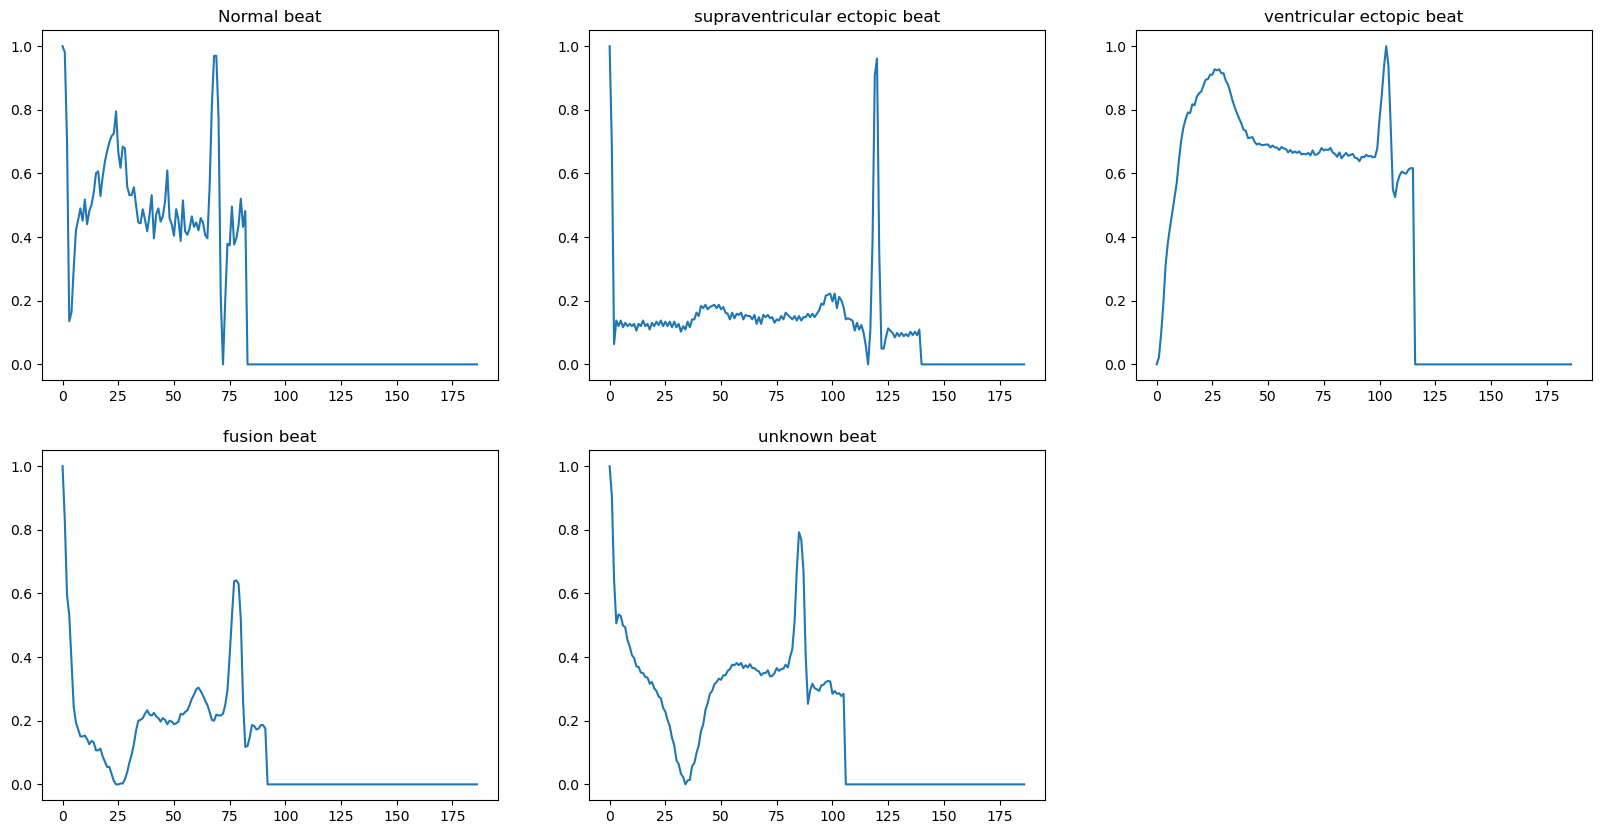

In [4]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot (range (0,187), (train_df.loc [train_df[187] ==0]).sample(1).iloc [:,:-1].values[0] )
plt.title ('Normal beat')

plt.subplot(2,3,2)
plt.plot ( (train_df.loc [train_df[187] ==1]).sample(1).iloc [:,:-1].values[0])
plt.title ('supraventricular ectopic beat')

plt.subplot(2,3,3)
plt.plot ( (train_df.loc [train_df[187] ==2]).sample(1).iloc [:,:-1].values[0])
plt.title ('ventricular ectopic beat')

plt.subplot(2,3,4)
plt.plot ( (train_df.loc [train_df[187] ==3]).sample(1).iloc [:,:-1].values[0])
plt.title ('fusion beat')

plt.subplot(2,3,5)
plt.plot ( (train_df.loc [train_df[187] ==4]).sample(1).iloc [:,:-1].values[0])
plt.title ('unknown beat')

plt.show()

# plot number of sample on every heartbeat

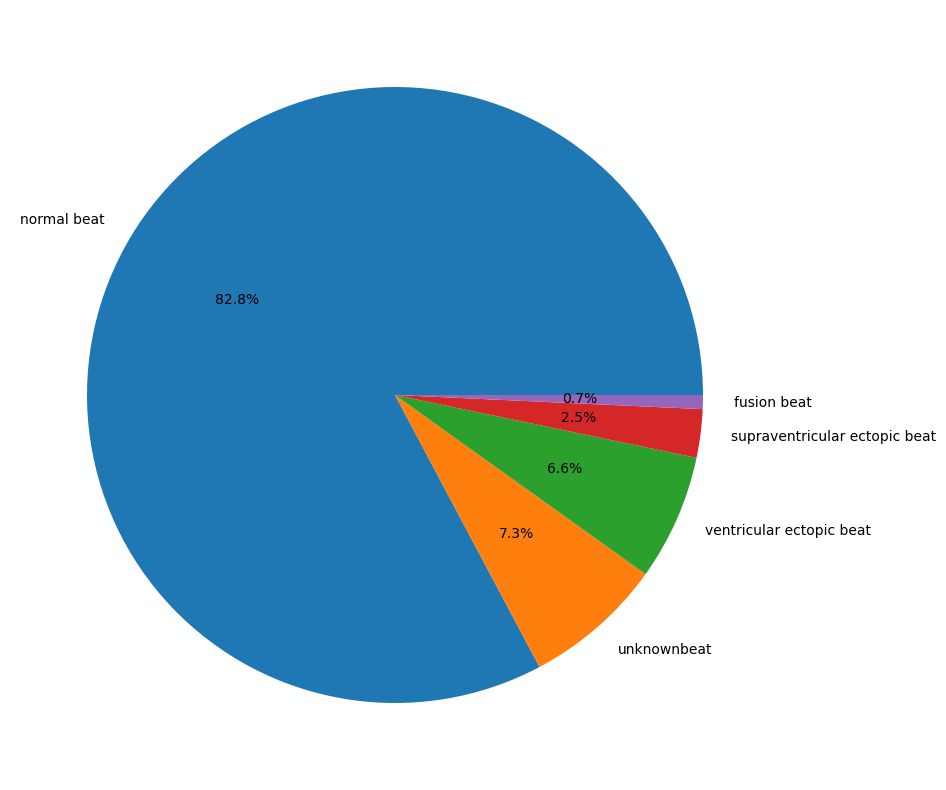

In [5]:
beats = ['normal beat' ,'unknownbeat','ventricular ectopic beat' , 'supraventricular ectopic beat' , 'fusion beat' ]
plt.figure(figsize=(20,10))
plt.pie (train_df [187].value_counts().values,labels = beats,autopct='%1.1f%%')
plt.show()

# over sampling input data

In [6]:
smote = SMOTE (sampling_strategy='all',random_state=42)
x =train_df.drop (columns =187)
y = train_df[187]
x,y = smote.fit_resample (x,y)
train_df = pd.concat([x,y],axis = 1)

# plot number of sample on every heartbeat after over sampling

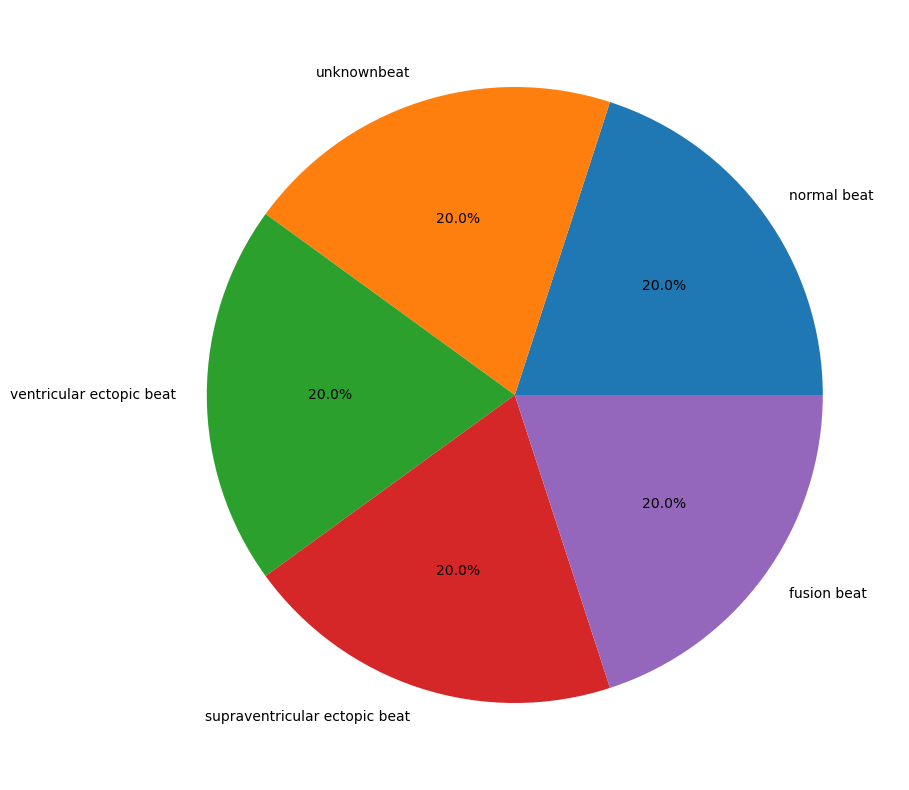

In [7]:
plt.figure(figsize=(20,10))
plt.pie (train_df [187].value_counts().values,labels = beats,autopct='%1.1f%%')
plt.show()

In [8]:
train_df = train_df.sample (frac =1) # randomize dataset

X_train = train_df.iloc [:,:-1].values
X_train = np.expand_dims(X_train,axis = -1)
y_train = to_categorical (train_df.iloc [:,-1].values)

X_test = test_df.iloc [:,:-1].values
X_test = np.expand_dims(X_test,axis = -1)
y_test = to_categorical (test_df.iloc [:,-1].values)

In [9]:
inputs = Input (shape = (X_train.shape[1],1))
x = Conv1D(filters=64, kernel_size=7, padding="causal",activation="relu")(inputs)
x = BatchNormalization()(x)
x = MaxPool1D(3)(x)
x = Conv1D(filters=64, kernel_size=5, padding="causal",activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool1D(3)(x)
'''x = Conv1D(filters=64, kernel_size=3, padding="causal",activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool1D(2)(x)'''
x = keras.layers.Bidirectional( keras.layers.LSTM(64, return_sequences=True))(x)
x = keras.layers.Bidirectional( keras.layers.LSTM(32))(x)
x = Dense (16,activation = 'relu')(x)
x = Dense(5,activation = 'softmax') (x)

model = Model([inputs], outputs=x)
model.summary()
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights = True,verbose = 1),
             ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='CategoricalCrossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),metrics=["accuracy"])
history = model.fit (X_train, y_train,epochs=50,batch_size=32,callbacks = [callbacks],validation_data=(X_test,y_test))
model.load_weights('model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 187, 64)           512       
                                                                 
 batch_normalization (BatchN  (None, 187, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 64)            20544     
                                                                 
 batch_normalization_1 (Batc  (None, 62, 64)           256   

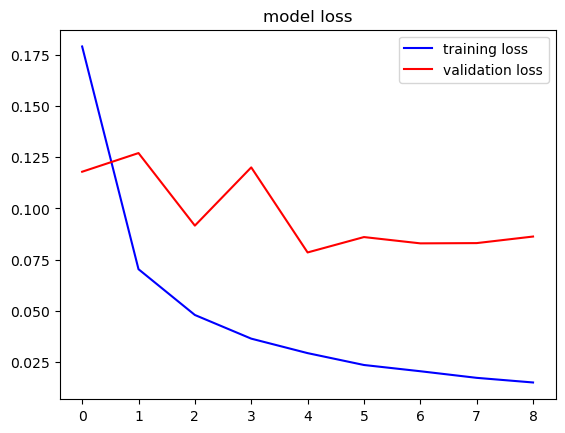

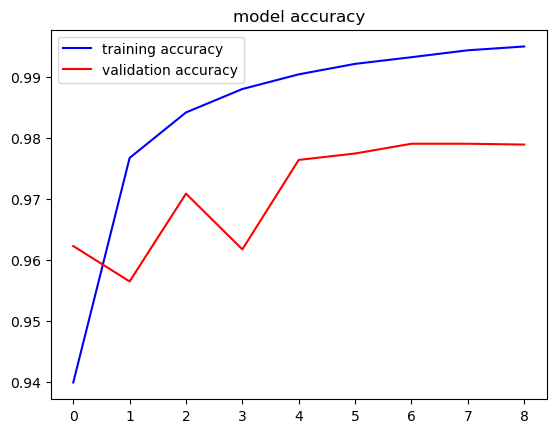

In [10]:
train_loss=history.history['loss']
val_loss = history.history['val_loss']
tarin_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range (len (train_loss)),train_loss,c='b',label = 'training loss')
plt.plot (range (len (val_loss)),val_loss,c='r',label = 'validation loss')
plt.title ('model loss')
plt.legend()
plt.show()

plt.plot(range (len (tarin_acc)),tarin_acc,c='b',label = 'training accuracy')
plt.plot (range (len (val_acc)),val_acc,c='r',label = 'validation accuracy')
plt.title ('model accuracy')
plt.legend()
plt.show()

# classfication report and confusion matrix

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     18118
         1.0       0.69      0.81      0.75       556
         2.0       0.96      0.95      0.96      1448
         3.0       0.62      0.88      0.72       162
         4.0       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.85      0.92      0.88     21892
weighted avg       0.98      0.98      0.98     21892



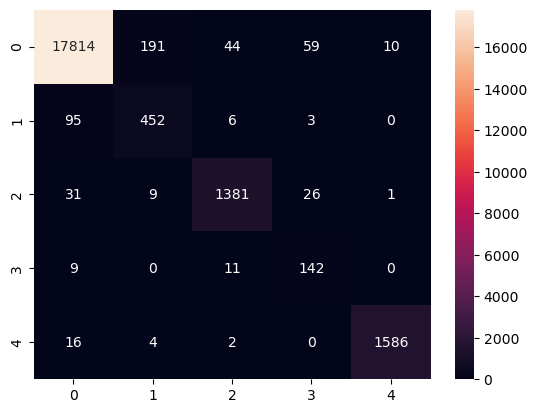

In [11]:
y_pred = np.argmax(model.predict (X_test,verbose = 0),axis =1)
y_true = test_df.iloc [:,-1].values
heatmap(confusion_matrix(y_true,y_pred),annot = True,fmt='d')
print (classification_report (y_true,y_pred))